In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from scipy import stats
from tqdm import tqdm

import sys 
sys.path.append("..")

from src.models import ContextSpaceNet
from src.utils import ratemap_collage, spatial_correlation

#### Feedforward network

In [2]:
model = ContextSpaceNet(n_in = 3, n_out = 100)
model = model.load("../saved_models/FF_context")

In [3]:
# Evaluate on 2x2 grid
res = 32
x = np.linspace(-1, 1, res)
y = x.copy()
xx, yy = np.meshgrid(x, y)

In [4]:
model.lam

0.1

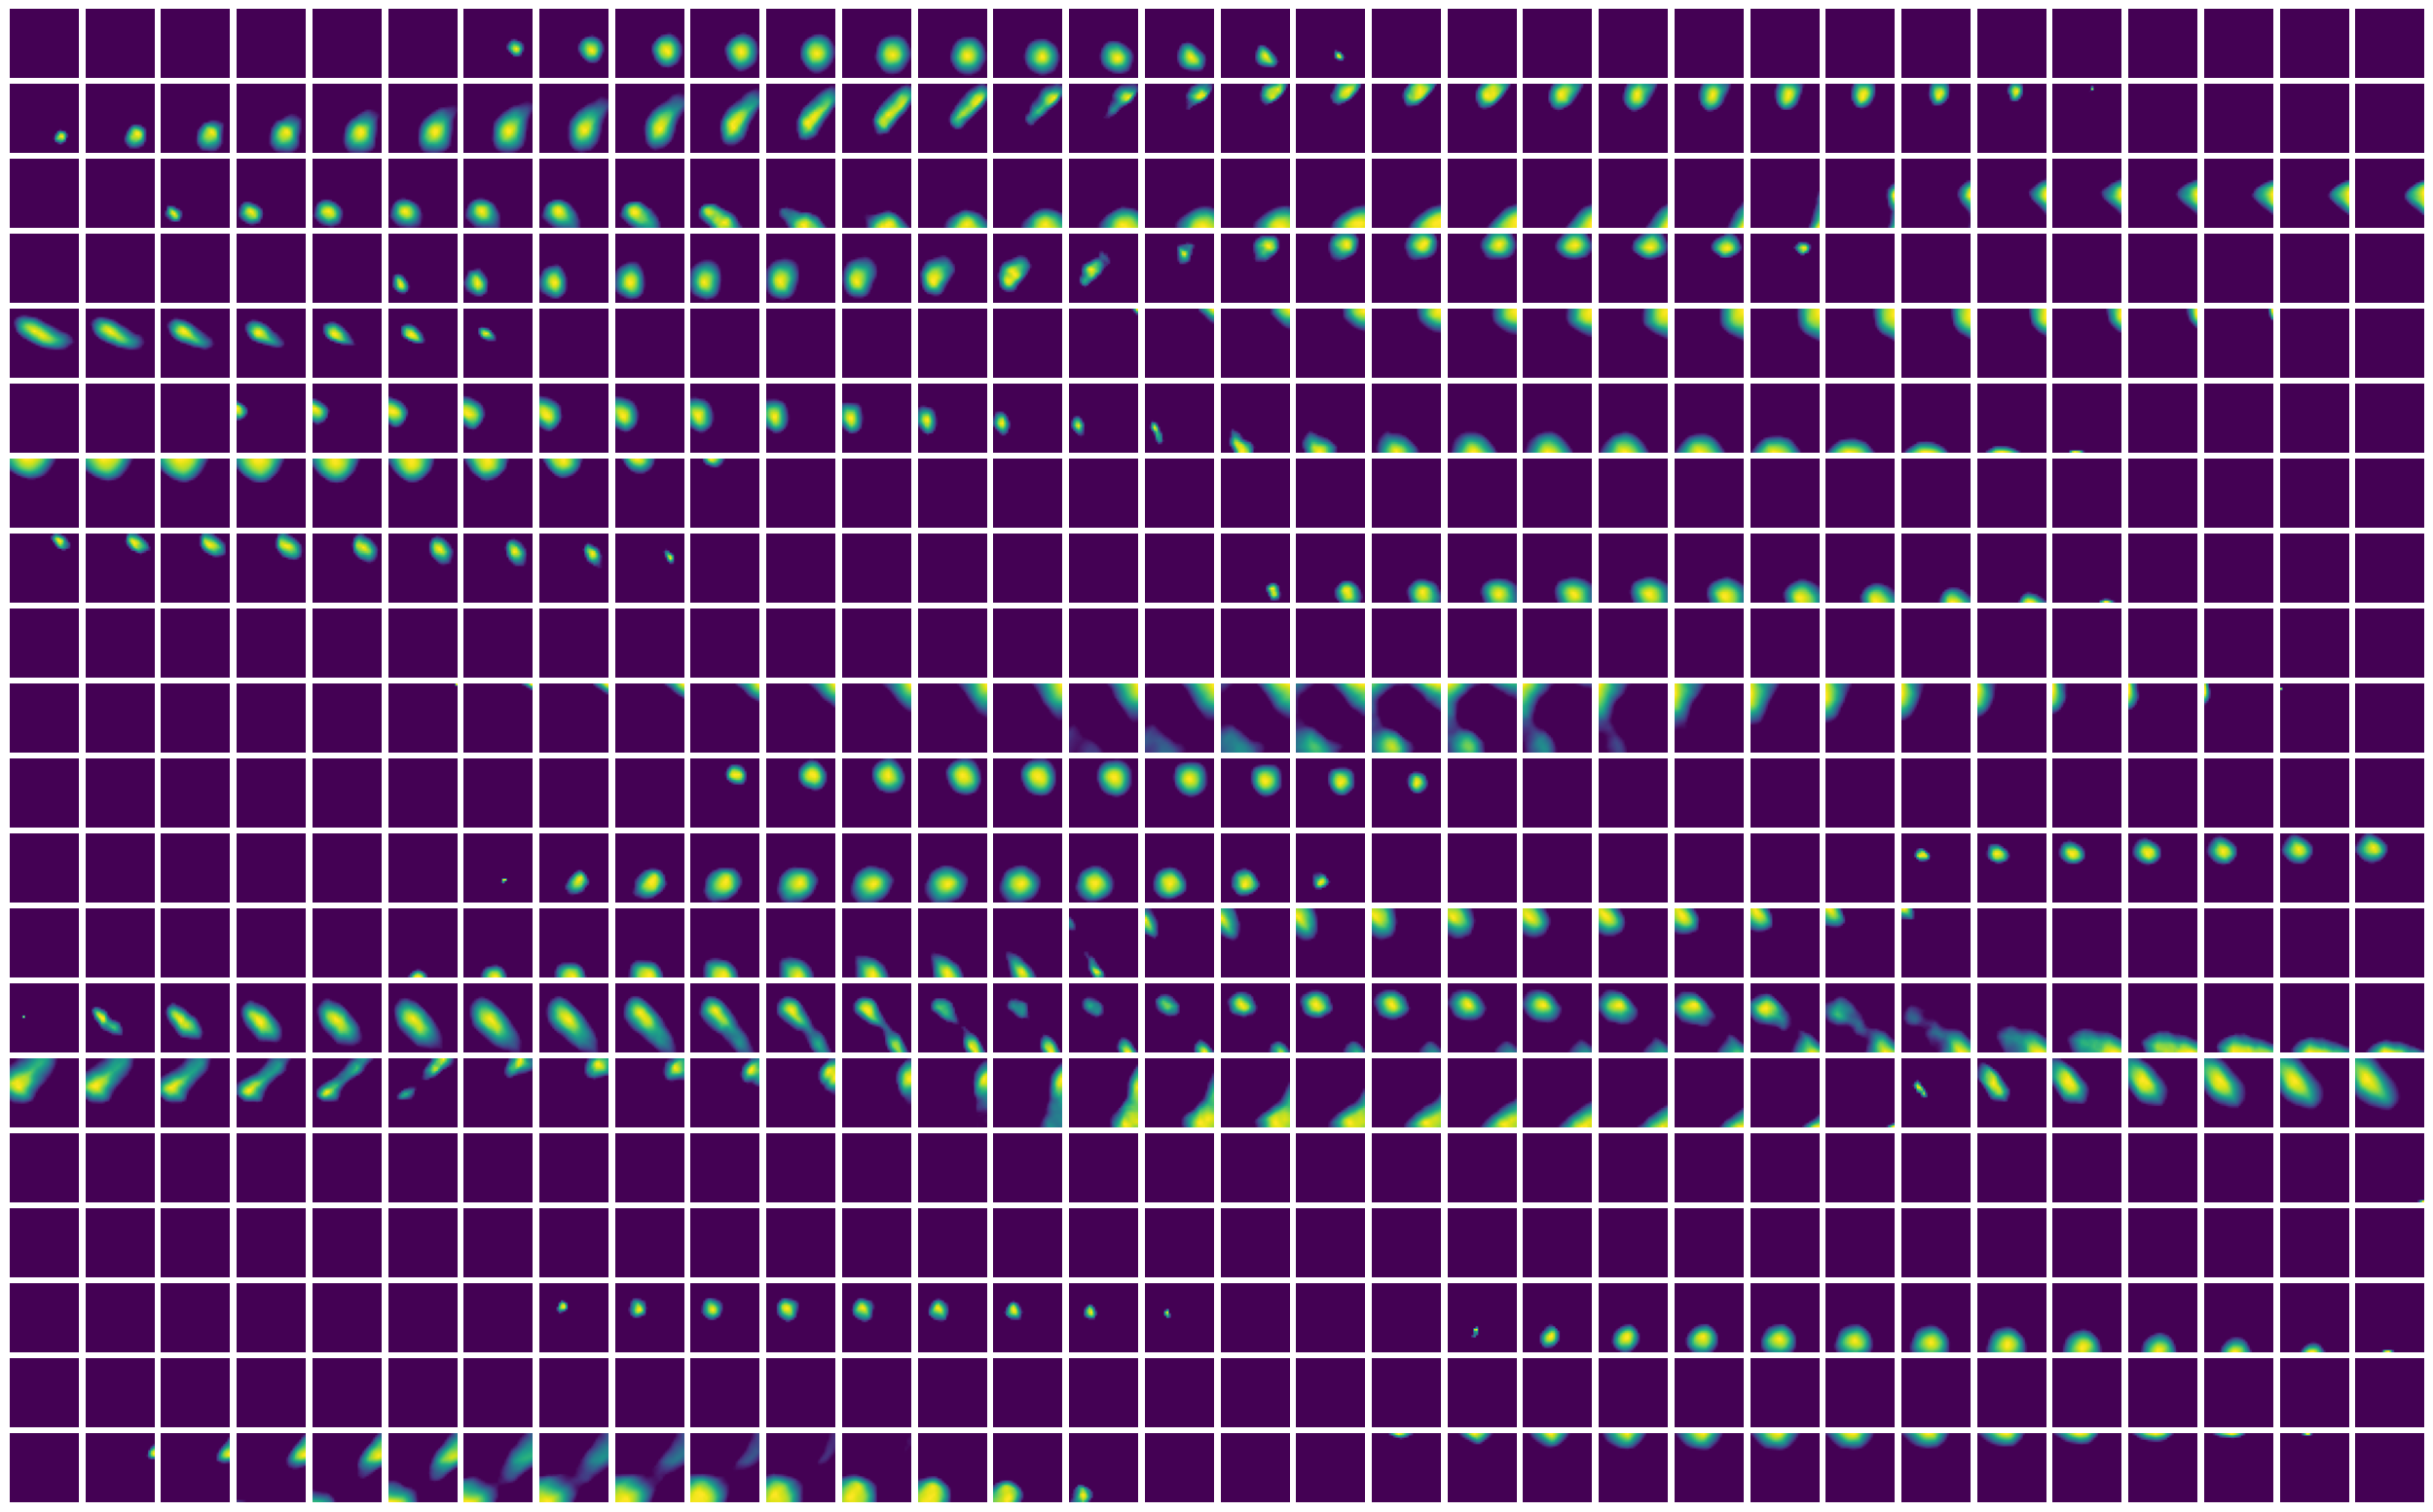

In [5]:
n = 20 # number of units to visualize
nc = 32 # number of contexts
contexts = np.linspace(-2, 2, nc)
fig, ax = plt.subplots(n, nc, figsize = (nc, n))

corrs = []

for i, c in enumerate(contexts):
    u = torch.tensor(np.stack([xx.ravel(), yy.ravel(), c*torch.ones(res**2)], axis=-1), dtype=torch.float32)
    corr, p = model(u)
    p = p.detach().numpy()
    for j in range(n):
        ax[j,i].imshow(p[...,j].reshape(res,res))
        ax[j,i].axis("off")
plt.subplots_adjust(hspace=0, wspace=0.1)

In [6]:
corrs = []

for i in range(nc):
    ua = torch.tensor(np.stack([xx.ravel(), yy.ravel(), contexts[i]*torch.ones(res**2)], axis=-1), dtype=torch.float32)
    _, pa = model(ua)
    pa = pa.detach().numpy()
    current = []
    for j in range(nc):
        ub = torch.tensor(np.stack([xx.ravel(), yy.ravel(), contexts[j]*torch.ones(res**2)], axis=-1), dtype=torch.float32)
        _, pb = model(ub)
        pb = pb.detach().numpy()
        current.append(spatial_correlation(pa.T, pb.T))
    corrs.append(current)

In [7]:
# fig, ax = plt.subplots(nc, nc, figsize = (20,20))
median_corrs = np.zeros((nc, nc))
counts = np.zeros((nc, nc))

for i in range(nc):
    for j in range(nc):
        # ax[i,j].hist(corrs[i][j], bins = 32)
        median_corrs[i,j] = np.median(corrs[i][j])
        counts[i,j] = len(corrs[i][j])

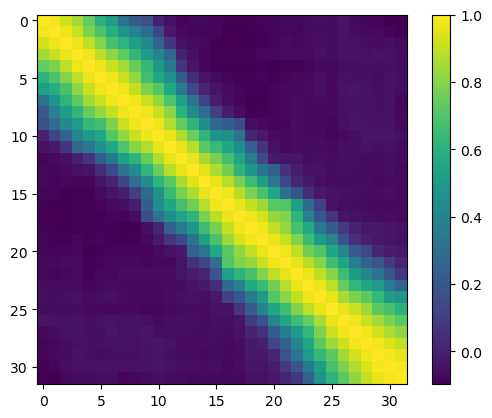

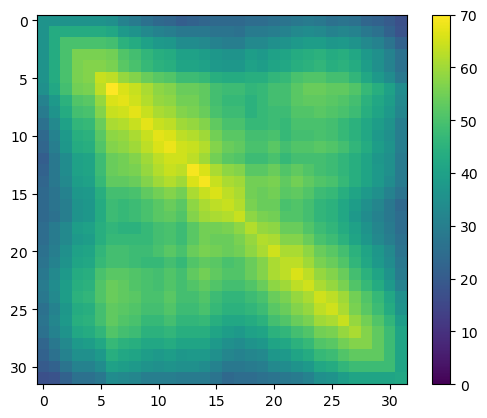

In [8]:
plt.imshow(median_corrs)
plt.colorbar()
plt.show()
plt.imshow(counts, vmin = 0)
plt.colorbar()